# Bike Sharing Demand Analysis & Time Series Forecasting using SARIMAX

#### Introducing Bike Sharing Data

"Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world. The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C." (Kaggle: https://www.kaggle.com/c/bike-sharing-demand/overview)

We are going to analyze hourly bike rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.

###### Data Fields

    datetime - hourly date + timestamp

    season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

    holiday - whether the day is considered a holiday

    workingday - whether the day is neither a weekend nor holiday

    weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
              2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
              3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
              4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

    temp - temperature in Celsius

    atemp - "feels like" temperature in Celsius

    humidity - relative humidity

    windspeed - wind speed

    casual - number of non-registered user rentals initiated
    
    registered - number of registered user rentals initiated

    count - number of total rentals

#### Introducing SARIMAX

Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX). This model encompasses not only the non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but also introduces the idea of external factors (environmental, economic, etc.), which can also influence a time series, and be used in forecasting. https://www.kaggle.com/smritisingh1997/bike-sharing

If the time series has seasonality then we have to use SARIMAX model which uses seasonal differencing. Seasonal differencing is similar to regular differencing expect for the regular differencing we have to subtract consecutive term whereas for seasonal differencing we subtract the value from the previous season.

The model is represented as SARIMAX(p,d,q)(P,D,Q)m

where p,d,q represents
p is the order of the AR term
q is the order of the MA term
d is the number of differencing to make the time series stationary.

where P,D,Q,m represents
P is Seasonal AR term
Q is seasonal MA term
D is seasonal difference order
m is the number of time steps for a single seasonal period

AR Model:
An auto regressive(AR) model is when a value from a time series is regressed on previous values from the same time series. In other words, the mathematical idea is as follows.

Today = Constant + Slope*Yesterday + Noise

MA Model:
The moving average(MA) can be described as the weighted sum of today and yesterday’s noise. In other words, the mathematical idea is as follows.

Today=Mean + Noise + Slope*Yesterday’s noise 

https://sailajakarra.medium.com/time-series-predictions-using-arima-sarimax-e6724844cae0


#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

#### Loading Data

Set datetime column as index, and change its data type to datetime in both train and test datasets.

In [2]:
train = pd.read_csv('train.csv', index_col='datetime', parse_dates=True)
test = pd.read_csv('test.csv', index_col='datetime', parse_dates=True)

Displaying top 5 rows of train dataset.

In [3]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Displaying top 5 rows of test dataset.

In [4]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


See summaries of train dataset.

In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [7]:
train.count().isnull()

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

There are no null values in the dataset.

Dropping the "casual" and "registered" columns from the train dataset, as in test dataset these values are not present at all.

In [8]:
train.drop('casual', axis=1, inplace=True)
train.drop('registered', axis=1, inplace=True)

### EDA & Processing

Let's see the frequency counts for each feature.

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

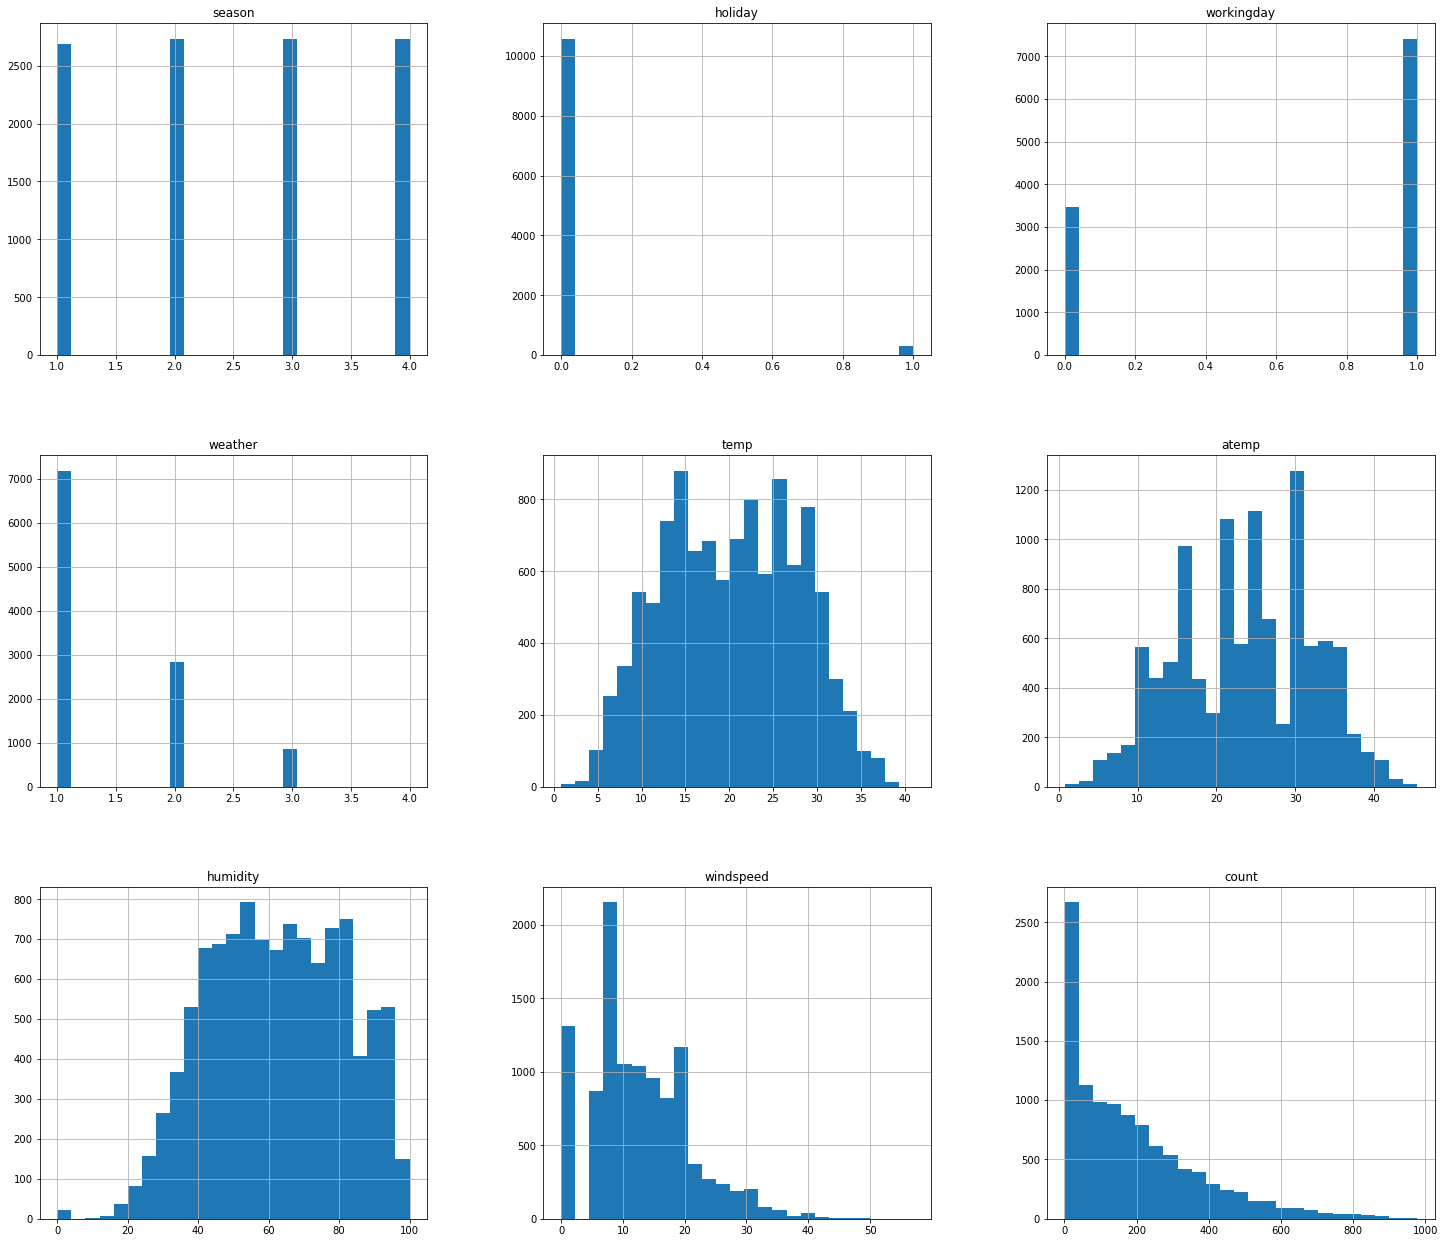

In [9]:
train.hist(figsize = (25,22), bins=25)

Check for outliers.

Text(0.5, 1.0, 'Count Distribution')

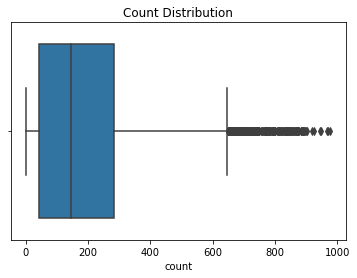

In [10]:
sns.boxplot(train['count']).set_title('Count Distribution')

We see that count has many outlier datapoints beyond the outer quartile.

Calculating quantiles to find and remove the outliers from the dataset.

In [11]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

season          2.0000
holiday         0.0000
workingday      1.0000
weather         1.0000
temp           12.3000
atemp          14.3950
humidity       30.0000
windspeed       9.9964
count         242.0000
dtype: float64


In [12]:
train.shape

(10886, 9)

In [13]:
train_without_outliers = train[~((train < (Q1 - 1.5*IQR)) | (train > (Q3 + 1.5*IQR))).any(axis=1)]

In [14]:
train_without_outliers.shape

(10044, 9)

We took out 842 datapoints, which is 7.7% of the data.

Text(0.5, 1.0, 'Count Distribution')

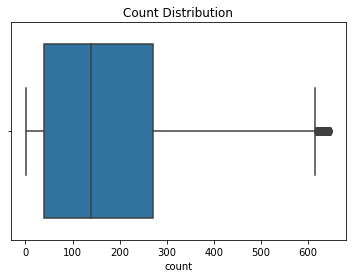

In [15]:
sns.boxplot(train_without_outliers['count']).set_title('Count Distribution')

We see that the number of outliers decreased significantly. 

Let's see the count distribution across season.

Text(0.5, 1.0, 'Count Distribution Across Season')

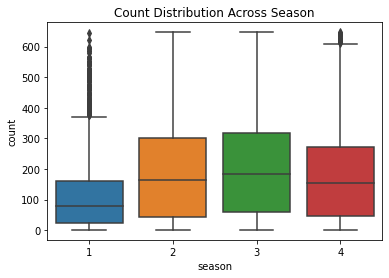

In [16]:
sns.boxplot(train_without_outliers['season'],train_without_outliers['count']).set_title('Count Distribution Across Season')

We see that season 1 (spring) has a significant drop in count. 

Let's see the count distribution across weather.

Text(0.5, 1.0, 'Count Distribution Across Weather')

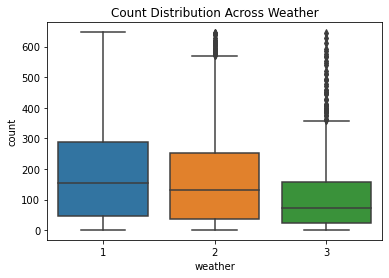

In [17]:
sns.boxplot(train_without_outliers['weather'],train_without_outliers['count']).set_title('Count Distribution Across Weather')

Hint: 
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
          2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

We see that the amount of rentals drop as it gets more rainy. 

Extract hour from datetime index.

In [18]:
train_without_outliers['hour'] = train_without_outliers.index.hour # hour in day
train_without_outliers['hour']

datetime
2011-01-01 00:00:00     0
2011-01-01 01:00:00     1
2011-01-01 02:00:00     2
2011-01-01 03:00:00     3
2011-01-01 04:00:00     4
                       ..
2012-12-19 19:00:00    19
2012-12-19 20:00:00    20
2012-12-19 21:00:00    21
2012-12-19 22:00:00    22
2012-12-19 23:00:00    23
Name: hour, Length: 10044, dtype: int64

Let's check out the count across hour of the day.

Text(0.5, 1.0, 'Count Distribution Across Hour')

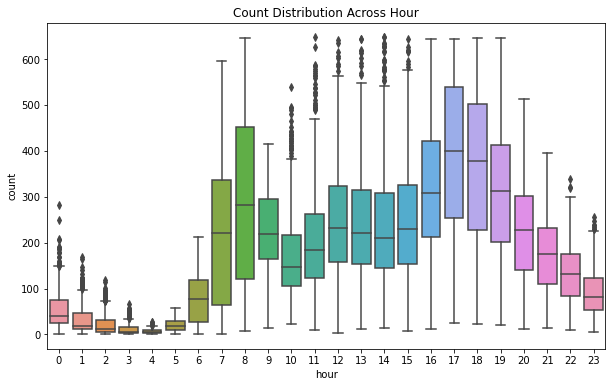

In [19]:
plt.figure(figsize = (10,6))
sns.boxplot(train_without_outliers['hour'],train_without_outliers['count']).set_title('Count Distribution Across Hour')

Peak hours are during commuting hours: between 7-8 in the morning, and 17-18 in the evening.

In [20]:
train_without_outliers.drop('hour',axis=1,inplace=True)

Finding the correlation value of target column (count) with other numerical variables present in the dataset

In [21]:
corr = train_without_outliers.corr()
corr['count'][:-1]

season        0.155804
holiday            NaN
workingday   -0.025378
weather      -0.128833
temp          0.379486
atemp         0.376000
humidity     -0.343446
windspeed     0.130973
Name: count, dtype: float64

Finding if multi collinearity is present in the data, if it is then drop that particular column from the dataset.

In [22]:
corr_matrix = train_without_outliers.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
train_without_outliers = train_without_outliers.drop(train_without_outliers[to_drop], axis=1)

In [23]:
train_without_outliers.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count
datetime,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16
2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40
2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32
2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13
2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1


The column 'atemp' was removed from the dataset.

Plotting distribution plot for the variables having skewness

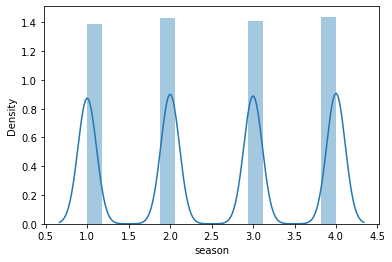

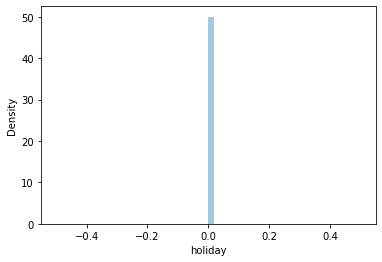

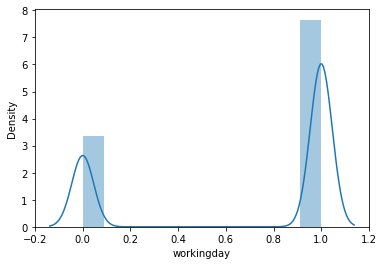

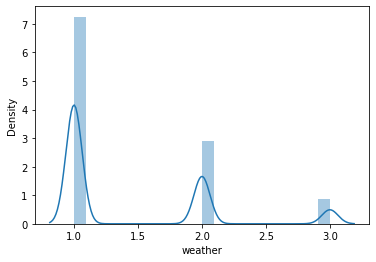

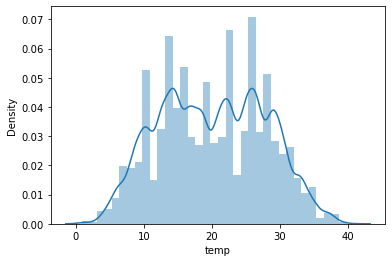

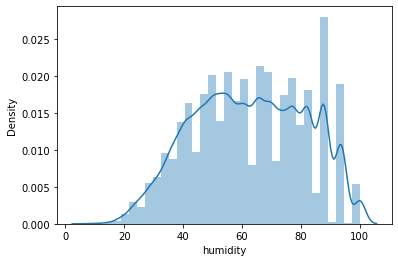

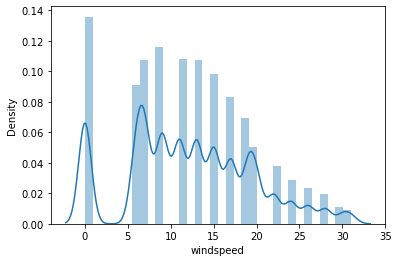

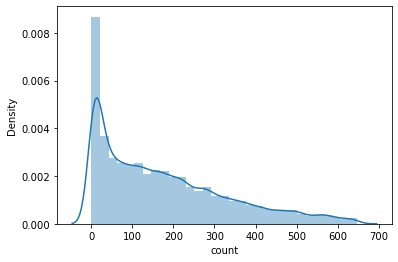

In [24]:
for i in (train_without_outliers.skew().index):
    plt.figure(i)
    sns.distplot(train_without_outliers[i], kde_kws={'bw':0.1})

Plotting scatter plot between "datetime index" and "count" column.

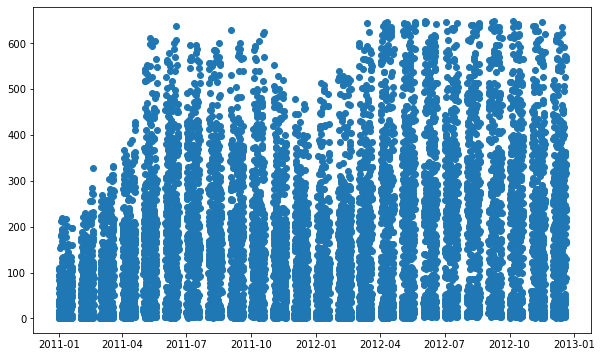

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(train_without_outliers.index, train_without_outliers['count'])

Finding if there is any skewness present in the entire dataset and if it is then fixing it through the boxcox1p transformation.

In [26]:
def fixing_skewness(df):
    numeric_feats = df.dtypes[df.dtypes != object].index
    
    skew_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    
    high_skew = skew_feats[abs(skew_feats) > 0.5].index
    
    for i in high_skew:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))
#         print(i)
        
fixing_skewness(train_without_outliers)

Following function helps in reducing, if any overfitting is present in the dataset, that is if any variable in the dataset, contains only one value in 99.94 of the cases

In [27]:
def overfit_reducer(df):
    overfit = []
    for i in df.columns:
        count = df[i].value_counts()
        zero_index_value = count.iloc[0]
        
        if (((zero_index_value / len(df)) * 100) > 99.94):
            overfit.append(i)
            
    overfit = list(overfit)
    return overfit

In [28]:
#Finding the list of overfitted features using above user-defined function
overfitted_features = overfit_reducer(train_without_outliers)
#Dropping the overfitted columns from the final dataframes
train_without_outliers.drop(overfitted_features, axis=1, inplace=True)

In [29]:
train_without_outliers.head()

,season,workingday,weather,temp,humidity,windspeed,count
datetime,,,,,,,
2011-01-01 00:00:00,1,0.0,0.719802,9.84,81,0.0,5.402087
2011-01-01 01:00:00,1,0.0,0.719802,9.02,80,0.0,8.849491
2011-01-01 02:00:00,1,0.0,0.719802,9.02,80,0.0,7.879047
2011-01-01 03:00:00,1,0.0,0.719802,9.84,75,0.0,4.797052
2011-01-01 04:00:00,1,0.0,0.719802,9.84,75,0.0,0.803221


The column 'holiday' was removed.

#### Run an ETS Decomposition

ETS stands for Error-Trend-Seasonality and is a model used for the time series decomposition. It decomposes the series into the error, trend and seasonality component.

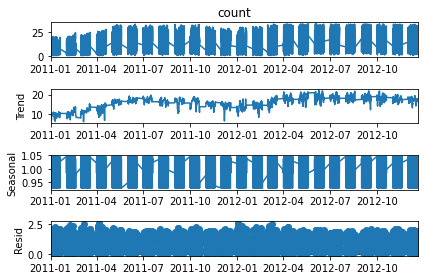

In [30]:
result = seasonal_decompose(train_without_outliers['count'], model='multiplicative', period=24)
result.plot();

#### Test for Stationarity

In [31]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [32]:
adf_test(train_without_outliers['count'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.259448e+00
p-value                 4.258690e-08
# lags used             3.600000e+01
# observations          1.000700e+04
critical value (1%)    -3.431004e+00
critical value (5%)    -2.861829e+00
critical value (10%)   -2.566924e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


We conclude that the data is stationary.

#### Run pmdarima.auto_arima to obtain recommended orders

In [33]:
# For SARIMA Orders we set seasonal=True and pass in an m value
# auto_arima(train_without_outliers['count'],seasonal=True,m=24, trace=True, n_jos=-1).summary()

Replacing the numerical values in Season and Weather column with the string values provided in the description of the dataset

In [34]:
train_without_outliers['season'] = train_without_outliers['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter' })
train_without_outliers['weather'] = train_without_outliers['weather'].replace({1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
                                        2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                        3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                                        4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog' })

Creating dummies for object data type and storing the result in data_dummies dataframe

In [35]:
data_dummies = pd.get_dummies(train_without_outliers, drop_first=True)
data_dummies.columns

Index(['workingday', 'weather', 'temp', 'humidity', 'windspeed', 'count',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [36]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10044 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   workingday     10044 non-null  float64
 1   weather        10044 non-null  float64
 2   temp           10044 non-null  float64
 3   humidity       10044 non-null  int64  
 4   windspeed      10044 non-null  float64
 5   count          10044 non-null  float64
 6   season_spring  10044 non-null  uint8  
 7   season_summer  10044 non-null  uint8  
 8   season_winter  10044 non-null  uint8  
dtypes: float64(5), int64(1), uint8(3)
memory usage: 578.7 KB


### Creating SARIMAX model

In [37]:
model = SARIMAX(train_without_outliers['count'], exog=data_dummies[:10045][['workingday', 'weather', 'temp', 'humidity', 'windspeed', 'count',
       'season_spring', 'season_summer', 'season_winter']],
                                            order=(2, 1, 2), seasonal_order=(1, 0, 1, 24), enforce_invertibility=False)

Fitting the model

In [38]:
results=model.fit()

Printing the summary of the result

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                10044
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 24)   Log Likelihood               93792.701
Date:                              Fri, 18 Jun 2021   AIC                        -187553.402
Time:                                      16:38:57   BIC                        -187437.968
Sample:                                           0   HQIC                       -187514.336
                                            - 10044                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
workingday    -2.927e-09   4.85e-06     -0.001      1.000   -9.51e-06    9.51e-06
weather        2.896e-09   6.69e-06      0.000      1.000   -1.31e-05    1.31e-05
temp          -2.129e-07   8.65e-07     -0.246      0.806   -1.91e-06    1.48e-06
humidity      -1.026e-06   1.37e-07     -7.510      0.000   -1.29e-06   -7.58e-07
windspeed     -6.401e-07   2.11e-07     -3.040      0.002   -1.05e-06   -2.27e-07
count             1.0000   2.23e-07   4.48e+06      0.000       1.000       1.000
season_spring -1.447e-10   3.76e-05  -3.84e-06      1.000   -7.38e-05    7.38e-05
season_summer   3.09e-10    2.7e-05   1.14e-05      1.000   -5.29e-05    5.29e-05
season_winter -4.082e-11      0.000   -3.4e-07      1.000      -0.000       0.000
ar.L1          7.974e-13   4.16e-10      0.002      0.998   -8.15e-10    8.16e-10
ar.L2          2.783e-13   8.19e-10      0.000      1.000    -1.6e-09     1.6e-09
ma.L1            -3.9008   1.56e-10   -2.5e+10      0.000      -3.901      -3.901
ma.L2             1.2617   2.78e-10   4.54e+09      0.000       1.262       1.262
ar.S.L24          0.7287   5.82e-10   1.25e+09      0.000       0.729       0.729
ma.S.L24         -0.6110   6.35e-10  -9.62e+08      0.000      -0.611      -0.611
sigma2         9.182e-11   2.26e-11      4.071      0.000    4.76e-11    1.36e-10
===================================================================================
Ljung-Box (L1) (Q):                2498.71   Jarque-Bera (JB):              1190.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.13
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.32e+27. Standard errors may be unstable.
"""

#### Obtain forecasted values

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 456.5 KB


In [41]:
start = len(train_without_outliers)
end = len(train_without_outliers) + len(test) - 1

fcast = results.predict(start=start, end=end, exog=data_dummies[:6493][['workingday', 'weather', 'temp', 'humidity', 'windspeed', 'count',
       'season_spring', 'season_summer', 'season_winter']]).rename('SARIMAX(1, 1, 1)x(2, 0, [1, 2], 2) Forecast')

Changing the data type of forecast to integer and dropping the index

In [42]:
fcast = fcast.astype('int64')
fcast = fcast.reset_index(drop=True)

In [43]:
fcast.index

RangeIndex(start=0, stop=6493, step=1)

In [44]:
fcast.max()

32

In [45]:
fcast.min()

0

<AxesSubplot:xlabel='datetime'>

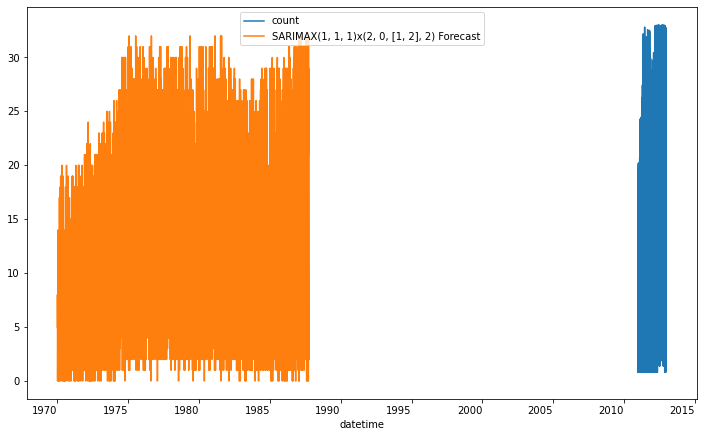

In [59]:
train_without_outliers['count'].plot(figsize=(12,8),legend=True)
fcast.plot(legend=True)

In [47]:
fcast.iloc[5650]

16

In [48]:
fcast.head(20)

0      5
1      8
2      7
3      4
4      0
5      0
6      1
7      1
8      3
9      5
10     8
11    10
12    12
13    13
14    14
15    14
16    13
17    11
18     8
19     8
Name: SARIMAX(1, 1, 1)x(2, 0, [1, 2], 2) Forecast, dtype: int64

#### Serializing

In [49]:
import pickle

In [50]:
with open('model_pickle','wb') as f:
    pickle.dump(model,f)

In [51]:
with open('fcast_pickle','wb') as g:
    pickle.dump(fcast,g)